In [51]:
# Imports dependencies
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf 
from sklearn.preprocessing import MinMaxScaler

In [52]:
# Importing the timesfm model (CPU version)
import timesfm

In [53]:
# Importing in the 200m parameter
tfm_one = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="cpu",
          per_core_batch_size=32,
          horizon_len=128,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-1.0-200m-pytorch"),
  )

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

In [54]:
# Importing in the 500m parameter
tfm_two = timesfm.TimesFm(
      hparams=timesfm.TimesFmHparams(
          backend="cpu",
          per_core_batch_size=32,
          horizon_len=128,
          num_layers=50,
          use_positional_embedding=False,
          context_len=2048,
      ),
      checkpoint=timesfm.TimesFmCheckpoint(
          huggingface_repo_id="google/timesfm-2.0-500m-pytorch"),
  )

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [55]:
# Download BTC-USD data
btc = yf.download('BTC-USD', start='2022-01-01', end='2024-03-01')
# Save the closing price data to a CSV
btc.to_csv("bitcoin.csv")
btc[['Close']].to_csv("bitcoin_prices.csv")
btc_close = btc[['Close']].copy()

[*********************100%***********************]  1 of 1 completed


In [56]:
# Bitcoin database
btc.head()

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2022-01-01,47686.812500,47827.312500,46288.484375,46311.746094,24582667004
2022-01-02,47345.218750,47881.406250,46856.937500,47680.925781,27951569547
2022-01-03,46458.117188,47510.726562,45835.964844,47343.542969,33071628362
2022-01-04,45897.574219,47406.546875,45752.464844,46458.851562,42494677905
2022-01-05,43569.003906,46929.046875,42798.222656,45899.359375,36851084859


In [57]:
# Bitcoin closing price filtered database
btc_close.head()

Price,Close
Ticker,BTC-USD
Date,
2022-01-01,47686.812500
2022-01-02,47345.218750
2022-01-03,46458.117188
2022-01-04,45897.574219
2022-01-05,43569.003906


In [58]:
print(btc_close.shape)
print(btc.shape)

(790, 1)
(790, 5)


In [59]:
# Restructuring dataset
btc_close["unique_id"] = "btc"
btc_close.reset_index(inplace = True)
btc_close.head()

Price,Date,Close,unique_id
Ticker,,BTC-USD,
0,2022-01-01,47686.812500,btc
1,2022-01-02,47345.218750,btc
2,2022-01-03,46458.117188,btc
3,2022-01-04,45897.574219,btc
4,2022-01-05,43569.003906,btc


In [71]:
# Restructuring the dataset cont.
btc_prepared = btc_close.rename(columns={'Close': 'values'})

In [72]:
btc_prepared = btc_prepared.rename(columns={'Date': 'ds'})

In [73]:
print(btc_prepared.columns)

MultiIndex([(       'ds',        ''),
            (   'values', 'BTC-USD'),
            ('unique_id',        '')],
           names=['Price', 'Ticker'])


In [76]:
btc_prepared.columns = ['ds', 'values', 'unique_id']
btc_prepared.head()

,ds,values,unique_id
0,2022-01-01,47686.812500,btc
1,2022-01-02,47345.218750,btc
2,2022-01-03,46458.117188,btc
3,2022-01-04,45897.574219,btc
4,2022-01-05,43569.003906,btc


In [89]:
btc_train = btc_prepared.head(662)
btc_train.shape
btc_train.head()

,ds,values,unique_id
0,2022-01-01,47686.812500,btc
1,2022-01-02,47345.218750,btc
2,2022-01-03,46458.117188,btc
3,2022-01-04,45897.574219,btc
4,2022-01-05,43569.003906,btc


In [90]:
# Calling the forecast_on_df method for the 200m parameter mode;
forecast_horizon = 128
forecast_context_len = 512

forecast_df_200m_128_512 = tfm_one.forecast_on_df(
    inputs=btc_train,
    freq='D',
    forecast_context_len = forecast_context_len,
    value_name = 'values', 
    model_name = 'timesfm',
    normalize = True,
    verbose = True,
)


Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.


In [91]:
# Calling the forecast_on_df method for the 200m parameter mode;
forecast_horizon = 128
forecast_context_len = 512

forecast_df_500m_128_512 = tfm_two.forecast_on_df(
    inputs=btc_train,
    freq='D',
    forecast_context_len = forecast_context_len,
    value_name = 'values', 
    model_name = 'timesfm',
    normalize = True,
    verbose = True,
)


Processing dataframe with single process.
Finished preprocessing dataframe.
Finished forecasting.


In [96]:
# forecast_df_200m_128_512.head()
print(forecast_df_200m_128_512.shape)
print(forecast_df_500m_128_512.shape)

(128, 12)
(128, 12)


In [97]:
forecast_df_200m_128_512.head()

,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,btc,2023-10-25,34023.468750,32927.546875,33363.023438,33626.375000,33896.546875,34023.468750,34264.148438,34446.921875,34804.460938,35216.023438
1,btc,2023-10-26,34025.304688,32348.314453,32988.492188,33265.816406,33663.011719,34025.304688,34275.007812,34615.902344,34931.800781,35592.644531
2,btc,2023-10-27,33425.359375,31550.052734,32310.197266,32775.242188,33007.183594,33425.359375,33801.386719,34064.382812,34634.523438,35462.753906
3,btc,2023-10-28,33206.308594,30975.902344,31712.609375,32464.691406,32716.738281,33206.308594,33441.640625,33913.820312,34457.132812,35304.218750
4,btc,2023-10-29,32828.273438,30670.535156,31506.542969,32058.947266,32386.144531,32828.273438,33368.203125,33752.609375,34428.773438,35282.750000


In [98]:
forecast_df_500m_128_512.head()

,unique_id,ds,timesfm,timesfm-q-0.1,timesfm-q-0.2,timesfm-q-0.3,timesfm-q-0.4,timesfm-q-0.5,timesfm-q-0.6,timesfm-q-0.7,timesfm-q-0.8,timesfm-q-0.9
0,btc,2023-10-25,33862.496094,31652.281250,32509.687500,33070.648438,33472.414062,33862.496094,34261.390625,34678.125000,35242.535156,36195.507812
1,btc,2023-10-26,33255.011719,30633.203125,31610.404297,32281.269531,32797.582031,33255.011719,33710.167969,34202.613281,34878.367188,35914.992188
2,btc,2023-10-27,32889.820312,30011.132812,31131.447266,31790.720703,32385.085938,32889.820312,33417.894531,33956.273438,34662.218750,35747.453125
3,btc,2023-10-28,32595.595703,29600.527344,30702.066406,31433.017578,32059.675781,32595.595703,33140.933594,33726.898438,34442.773438,35618.453125
4,btc,2023-10-29,32153.433594,29072.716797,30186.736328,30945.378906,31568.339844,32153.433594,32729.509766,33348.878906,34116.699219,35360.859375


In [108]:
# Preparing the data to be plotted
btc_forecast_200m = forecast_df_200m_128_512[['unique_id', 'ds', 'timesfm-q-0.5']]
btc_forecast_500m = forecast_df_500m_128_512[['unique_id', 'ds', 'timesfm-q-0.5']]
# btc_forecast_200m.head()
# btc_forecast_500m.head()
btc_test = btc_prepared.tail(128)
btc_test

,ds,values,unique_id
662,2023-10-25,34502.820312,btc
663,2023-10-26,34156.648438,btc
664,2023-10-27,33909.800781,btc
665,2023-10-28,34089.574219,btc
666,2023-10-29,34538.480469,btc
...,...,...,...
785,2024-02-25,51733.238281,btc
786,2024-02-26,54522.402344,btc
787,2024-02-27,57085.371094,btc
788,2024-02-28,62504.789062,btc


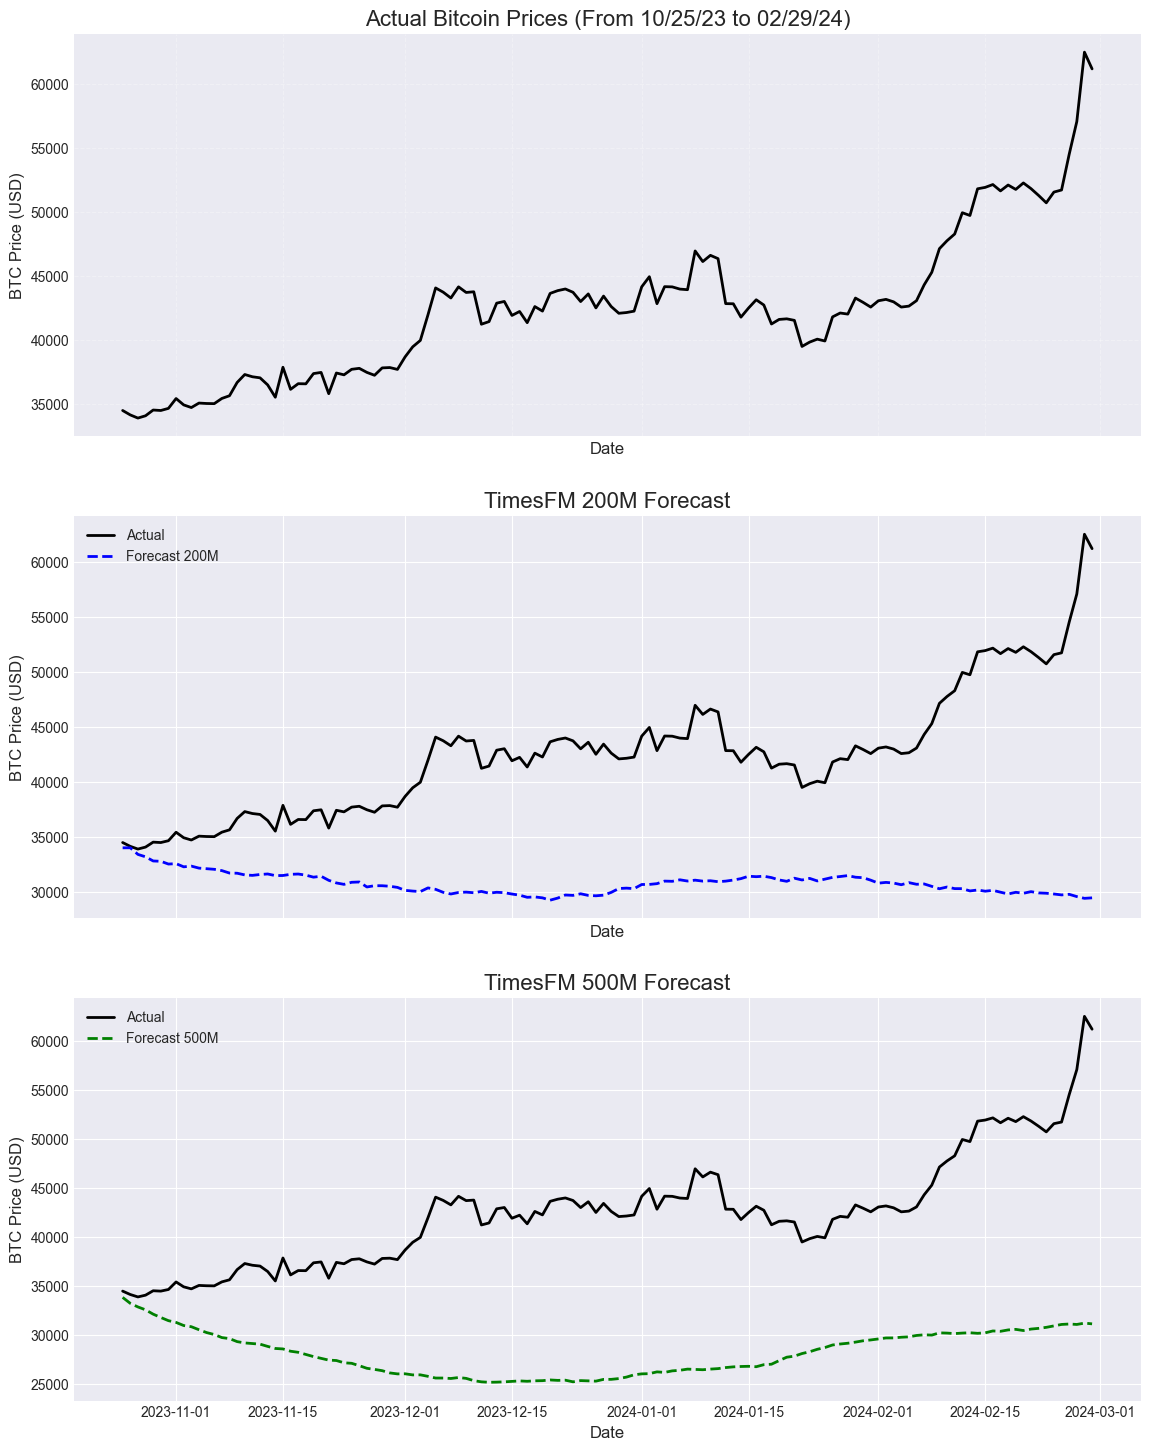

<Figure size 640x480 with 0 Axes>

In [111]:
# Plotting the data
# Setup the plot environment
plt.style.use('seaborn-v0_8-darkgrid')
fig, axs = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

# Plot Actual Prices
ax = axs[0]
ax.plot(btc_test['ds'], btc_test['values'], color='black', linewidth=2)
ax.set_title("Actual Bitcoin Prices (From 10/25/23 to 02/29/24)", fontsize=16)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("BTC Price (USD)", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.3)

# Plot TimesFM 200M Forecast
ax = plt.subplot(312)
ax.plot(btc_test['ds'], btc_test['values'], label='Actual', color='black', linewidth=2)
ax.plot(btc_forecast_200m['ds'], btc_forecast_200m['timesfm-q-0.5'], linestyle='--', linewidth=2, color='blue', label='Forecast 200M')
ax.set_title("TimesFM 200M Forecast", fontsize=16)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("BTC Price (USD)", fontsize=12)
ax.legend(['Actual', 'Forecast 200M'])
ax.grid(True)

# Plot TimesFM 500M Forecast
ax = plt.subplot(313)
ax.plot(btc_test['ds'], btc_test['values'], color='black', linewidth=2)
ax.plot(btc_forecast_500m['ds'], btc_forecast_500m['timesfm-q-0.5'], linestyle='--', linewidth=2, color='green', label='Forecast 500M')
ax.set_title("TimesFM 500M Forecast", fontsize=16)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("BTC Price (USD)", fontsize=12)
ax.legend(['Actual', 'Forecast 500M'])
ax.grid(True)

plt.tight_layout(pad=2.5)
plt.show()